In [1]:
import os
import json 
import argparse
import numpy as np
import math
import pickle
import datetime
import time
import logging
import itertools
import IPython

%load_ext autoreload
%autoreload 2

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

You can specify an URL to an image:

In [2]:
url = 'https://cdn.topofart.com/images/artists/John_Singer_Sargent/paintings/sargent029.jpg'
import urllib.request
urllib.request.urlretrieve(url, "input_img.jpg")
imgpath = os.path.abspath("input_img.jpg")

Or specify an image from the styletransfer art dataset:

In [3]:
imgpath = '/home/althausc/nfs/data/coco_17_medium/val2017_styletransfer/000000000785_050351.jpg'
imgpath = '/home/althausc/nfs/data/artimages/painterbynumbers1k/32287.jpg'

Show the loaded image:

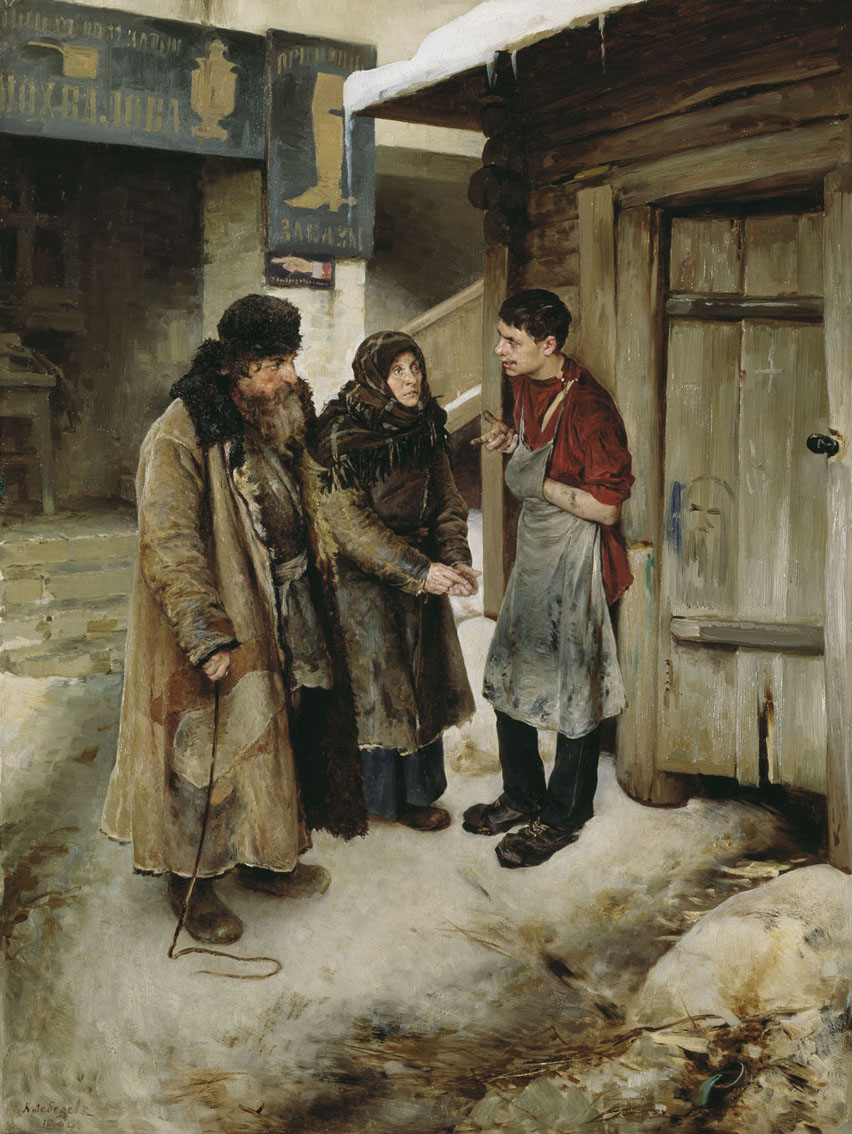

In [4]:
from IPython.display import Image, display
display(Image(filename=imgpath))

Optional: Select a sub-region of the image for partial image search

Output()

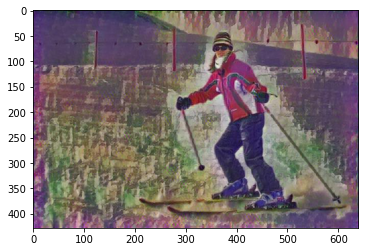

In [8]:
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.widgets as widgets
from predict_search_modules import cropImage

from ipywidgets import Output
output = Output()
display(output)

@output.capture()
def onselect(eclick, erelease, resize=True):
    global imgpath
    if eclick.ydata>erelease.ydata:
        eclick.ydata,erelease.ydata=erelease.ydata,eclick.ydata
    if eclick.xdata>erelease.xdata:
        eclick.xdata,erelease.xdata=erelease.xdata,eclick.xdata
    p1 = [eclick.xdata, eclick.ydata]
    p2 = [erelease.xdata, erelease.ydata]
   
    ax.set_ylim(erelease.ydata,eclick.ydata)
    ax.set_xlim(eclick.xdata,erelease.xdata)
    #fig.canvas.draw(eclick.xdata,erelease.xdata) 
    
    imgpath = cropImage(imgpath, p1, p2, resize=resize)

fig = plt.figure()
ax = fig.add_subplot(111)
im = Image.open(imgpath)
arr = np.asarray(im)
plt_image=plt.imshow(arr)
rs=widgets.RectangleSelector(
    ax, onselect, drawtype='box',
    rectprops = dict(facecolor='red', edgecolor = 'black', alpha=0.5, fill=True))
plt.show()


Infer the scene graph from the image & Visualize the result:

/home/althausc/nfs/data/artimages/painterbynumbers1k/32287.jpg
SCENE GRAPH PREDICTION ...
Logfile:  /home/althausc/master_thesis_impl/results/logs/jupyter-notebook/graphbranch/1-scenegraph.txt
/home/althausc/master_thesis_impl/scripts/singularity/ubuntu_srun_G1d4-2.sh python3.6 -m torch.distributed.launch	 --master_port 10031	 --nproc_per_node=1 /home/althausc/master_thesis_impl/Scene-Graph-Benchmark.pytorch/tools/relation_test_net.py	 --config-file "/home/althausc/master_thesis_impl/Scene-Graph-Benchmark.pytorch/configs/e2e_relation_X_101_32_8_FPN_1x.yaml" 	 MODEL.ROI_RELATION_HEAD.USE_GT_BOX False	 MODEL.ROI_RELATION_HEAD.USE_GT_OBJECT_LABEL False	 MODEL.ROI_RELATION_HEAD.PREDICTOR CausalAnalysisPredictor	 MODEL.ROI_RELATION_HEAD.CAUSAL.EFFECT_TYPE TDE	 MODEL.ROI_RELATION_HEAD.CAUSAL.FUSION_TYPE sum	 MODEL.ROI_RELATION_HEAD.CAUSAL.CONTEXT_LAYER motifs	 TEST.IMS_PER_BATCH 1	 DTYPE "float16"	 GLOVE_DIR /home/althausc/master_thesis_impl/Scene-Graph-Benchmark.pytorch/checkpoints/sgdet_tr

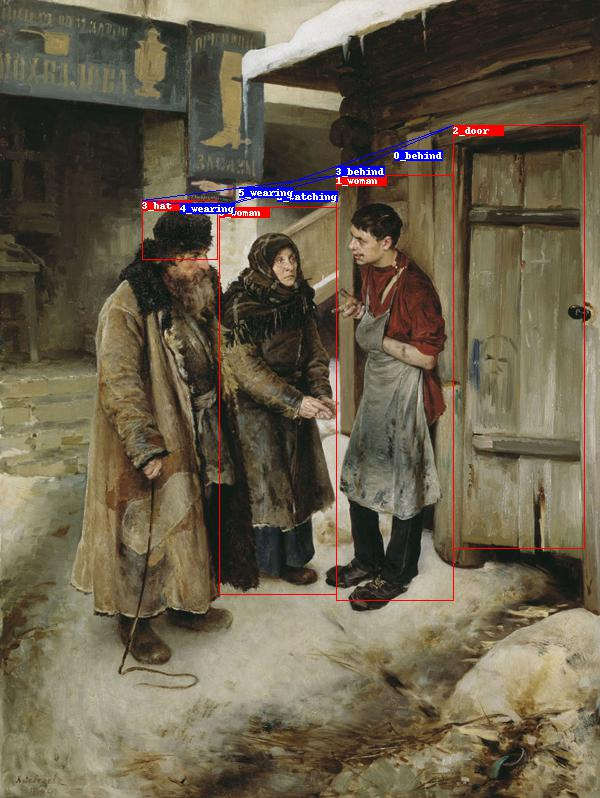

Box labels: 
0_woman; 0.7793079018592834
1_woman; 0.7131454944610596
2_door; 0.6919968724250793
3_hat; 0.6765254735946655
Rel labels: 
2_door => behind => 1_woman; 0.6302128434181213	0
0_woman => watching => 1_woman; 0.405311644077301	1
1_woman => watching => 0_woman; 0.3726125955581665	2
2_door => behind => 0_woman; 0.30093586444854736	3
0_woman => wearing => 3_hat; 0.23485076427459717	4
1_woman => wearing => 3_hat; 0.23204579949378967	5
Actual Top-k rel: 
2_door => behind => 1_woman; 0.6302128434181213	0
0_woman => watching => 1_woman; 0.405311644077301	1
1_woman => watching => 0_woman; 0.3726125955581665	2
2_door => behind => 0_woman; 0.30093586444854736	3
0_woman => wearing => 3_hat; 0.23485076427459717	4
1_woman => wearing => 3_hat; 0.23204579949378967	5



In [5]:
from predict_search_modules import predict_scenegraph, visualize_scenegraph

annpath = predict_scenegraph(imgpath)

filterlabels = True #False
imgpath, anns = visualize_scenegraph(annpath, filterlabels)
print(imgpath)
display(Image(filename=imgpath))

with open(anns, 'r') as f:
    print(f.read())


Filter out best predictions & Transform into Graph2Vec input format:

In [6]:
from predict_search_modules import transform_into_g2vformat

#annpath = 'test'
relsasnodes = True
graphfile = transform_into_g2vformat(annpath,relsasnodes)

TRANSFORM PREDICTIONS INTO GRAPH2VEC FORMAT ...
TRANSFORM PREDICTIONS INTO GRAPH2VEC FORMAT DONE.
Graphfile:  /home/althausc/master_thesis_impl/Scene-Graph-Benchmark.pytorch/out/predictions/single/12-07_10-05-14/12-07_10-06-15/graphs-topk.json


Search best matching image (respectively graph) from previous trained model:

In [10]:
from predict_search_modules import search_topk
k = 10
rw = False #True
rm = 'jaccard' #'euclid' 
filetopk = search_topk(graphfile, k, reweight=rw, r_mode=rm)


GRAPH2VEC PREDICTION & RETRIEVAL ...
inputfile: /home/althausc/master_thesis_impl/Scene-Graph-Benchmark.pytorch/out/predictions/single/12-04_18-45-23/12-04_18-46-52/graphs-topk.json


RuntimeError: Scene graph search failed.

Show images in ranking:

Reading from file:  /home/althausc/master_thesis_impl/retrieval/out/scenegraphs/09/25_16-17-38/topkresults.json
['g_/home/althausc/nfs/data/styleimgs_test/styles/75379.jpg', 0.07508829236030579]
['g_/home/althausc/nfs/data/styleimgs_test/styles/62187.jpg', 0.05341362580657005]
['g_/home/althausc/nfs/data/styleimgs_test/styles/92741.jpg', -0.02689141035079956]
4 3
['Query Image', 0.07508829236030579, 0.05341362580657005, -0.02689141035079956]



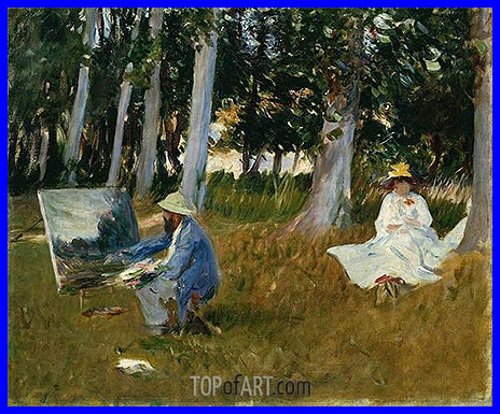
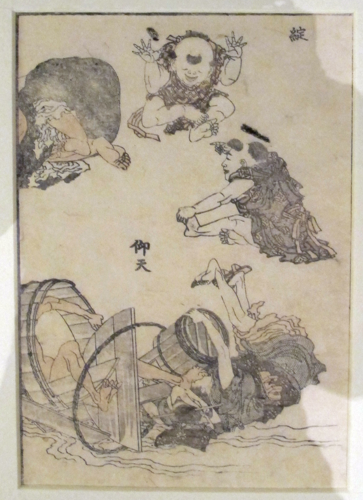
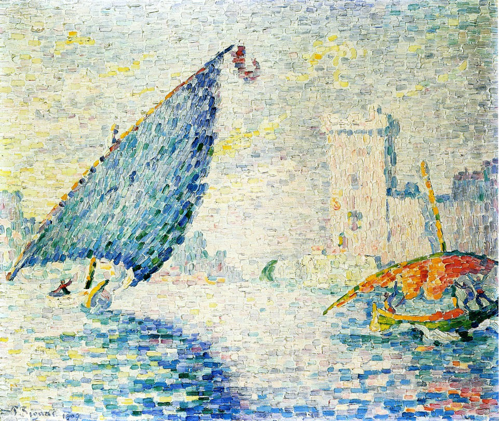

In [12]:
import ipyplot
from predict_search_modules import getImgs, treshIndex, drawborder

imgs, scores = getImgs(filetopk)
queryim = drawborder(imgpath)
imgs.insert(0,queryim)

tresh = 0.01
k = treshIndex(tresh, filetopk) + 1
print(len(imgs), k)

ipyplot.plot_images(imgs[:k], labels=None, scores=scores[:k], max_images=30, img_width=250)

In [8]:
%load_ext autoreload
%autoreload 2